**Importing Libraries Required**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**Importing Dataset**

In [4]:
file_path=r"C:\Users\himan\Downloads\ecommerce_furniture_dataset_2024 (1).csv"
df=pd.read_csv(file_path)

**EDA Data Cleaning and preprocessing**

In [6]:
df.head()

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [7]:
df.isnull().sum()

productTitle        0
originalPrice    1513
price               0
sold                0
tagText             3
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   productTitle   2000 non-null   object
 1   originalPrice  487 non-null    object
 2   price          2000 non-null   object
 3   sold           2000 non-null   int64 
 4   tagText        1997 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


In [9]:
df.shape

(2000, 5)

In [10]:
df.describe()

,sold
count,2000.000000
mean,23.493500
std,254.094061
min,0.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,10000.000000


In [11]:
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True)
df['originalPrice']=df['originalPrice'].replace({'\$':'',',':''},regex=True)

In [12]:
df['originalPrice']=df['originalPrice'].astype('float')
df['price']=df['price'].astype('float')

In [13]:
df['originalPrice'].describe()

count     487.000000
mean      256.028090
std       422.737861
min         3.630000
25%        31.770000
50%        88.310000
75%       314.125000
max      3265.130000
Name: originalPrice, dtype: float64

In [14]:
df['originalPrice'].skew()

3.5174372214836365

In [15]:
df['originalPrice'].fillna(df['originalPrice'].median(), inplace=True)

In [16]:
df.isna().sum()

productTitle     0
originalPrice    0
price            0
sold             0
tagText          3
dtype: int64

<Axes: xlabel='price', ylabel='Density'>

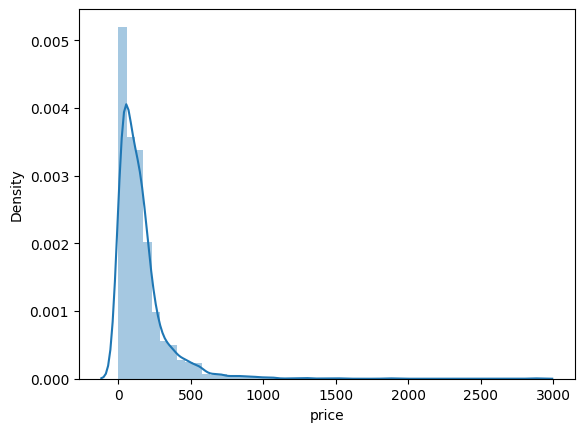

In [17]:
sns.distplot(df['price'])

<Axes: xlabel='originalPrice', ylabel='Density'>

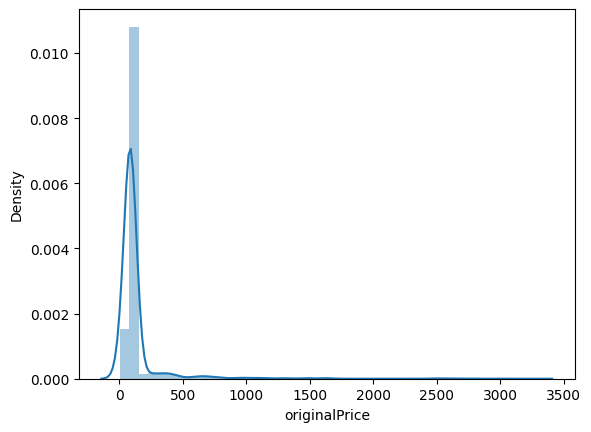

In [18]:
sns.distplot(df['originalPrice'])

<Axes: xlabel='price', ylabel='sold'>

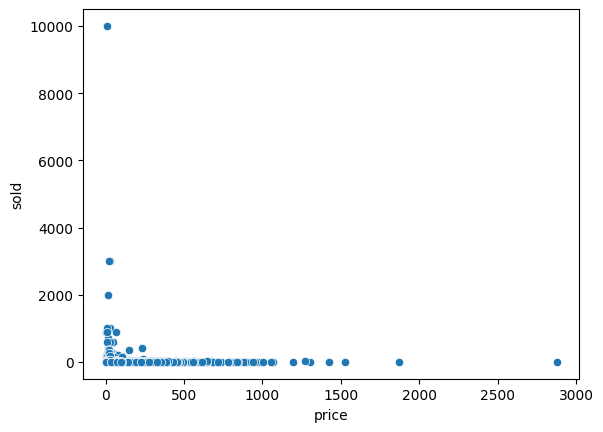

In [19]:
sns.scatterplot(x='price', y='sold', data=df)

In [20]:
df['tagText'] = df['tagText'].apply(lambda x: x if x in ['Free shipping', '+Shipping: $5.09'] else 'others')

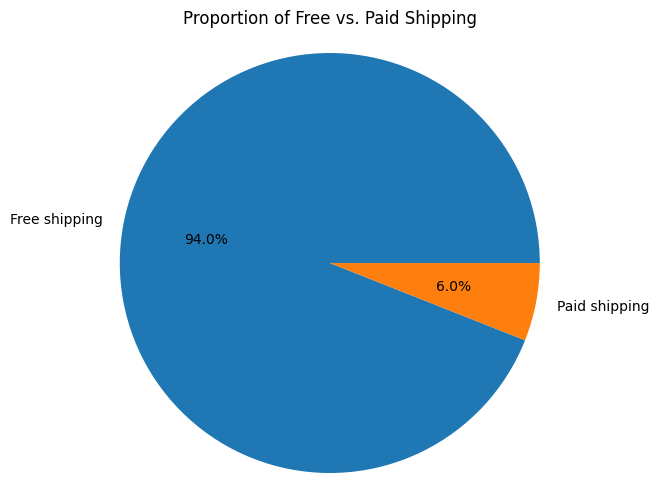

In [21]:
shipping_counts = df['tagText'].value_counts()
shipping = pd.DataFrame({'value': shipping_counts.values}, index=shipping_counts.index)
pie_data = {
    'Free shipping': shipping.loc['Free shipping', 'value'],
    'Paid shipping': shipping['value'].sum() - shipping.loc['Free shipping', 'value']
}

pie_df = pd.Series(pie_data)

plt.figure(figsize=(8, 6))
plt.pie(pie_df, labels=pie_df.index, autopct='%1.1f%%', startangle=360)
plt.title('Proportion of Free vs. Paid Shipping')
plt.axis('equal')  
plt.show()

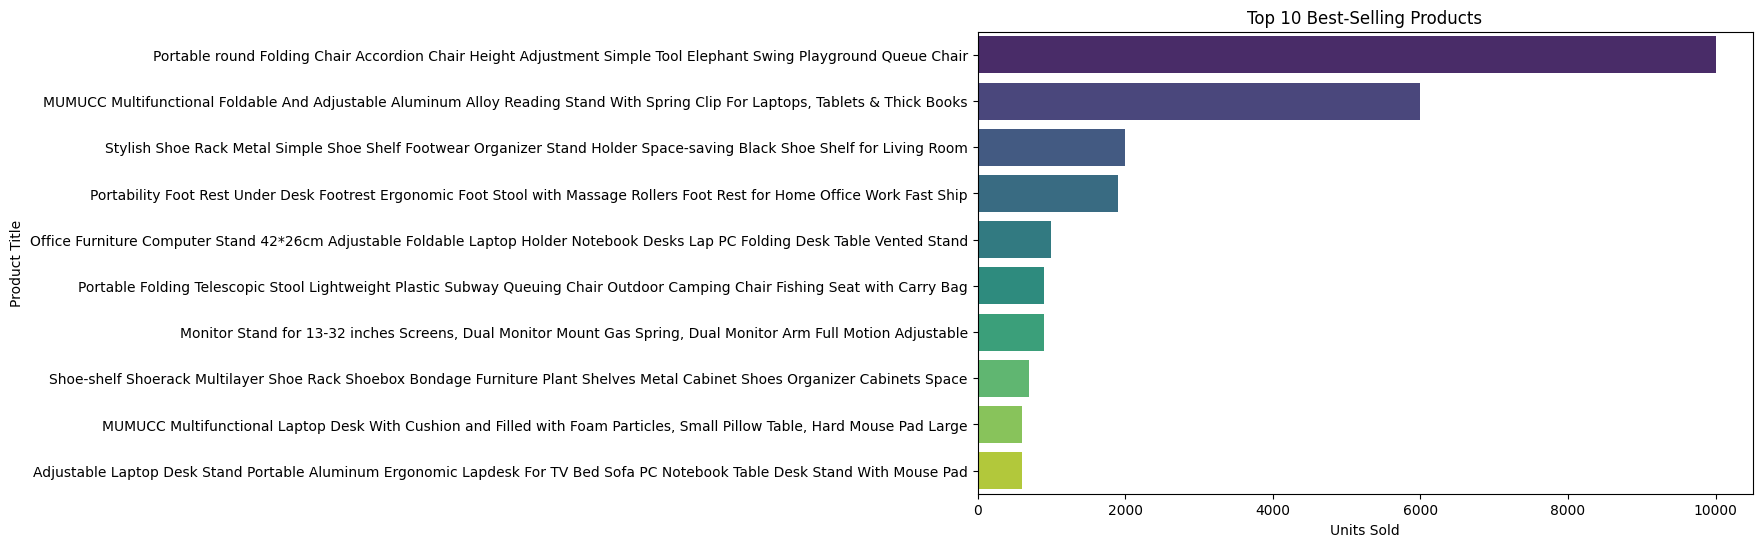

In [22]:
top_products = df.groupby('productTitle')['sold'].sum().reset_index()
top_products = top_products.sort_values(by='sold', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='sold', y='productTitle', data=top_products, palette='viridis', hue='productTitle', dodge=False)
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Units Sold')
plt.ylabel('Product Title')
plt.legend([], [], frameon=False)  # Removes unnecessary legend
plt.show()

<Axes: xlabel='tagText', ylabel='sold'>

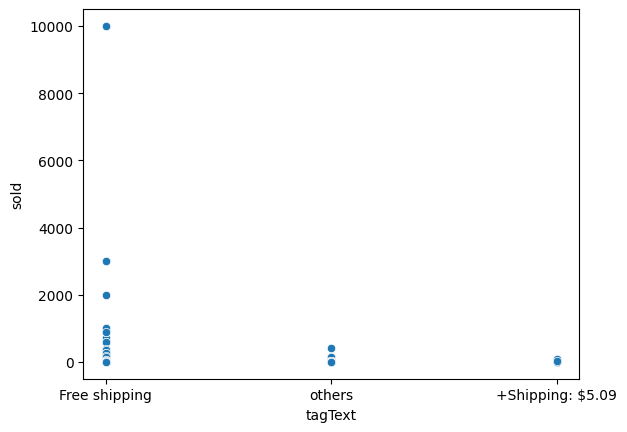

In [23]:
 sns.scatterplot(x='tagText', y='sold', data=df)

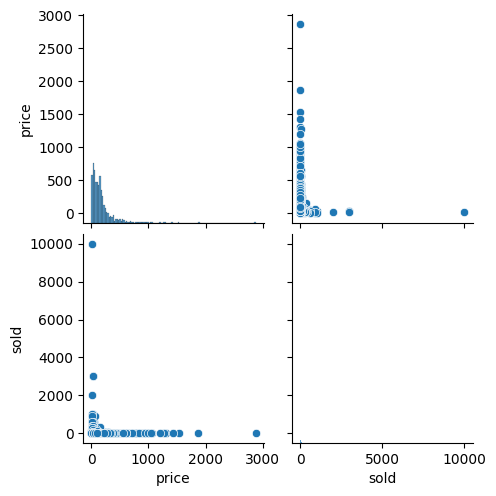

In [24]:
filtered_df = df[df['tagText'] == 'Free shipping']
sns.pairplot(filtered_df[['price', 'sold']])

Applying log transformation

In [26]:
df['sold'] = np.log1p(df['sold'])

Creating new features called total cost and shipping

In [41]:
from sklearn.preprocessing import LabelEncoder
df['shipping'] = df['tagText'].str.extract(r'(\d+\.\d+)').fillna(0).astype('float')
df['total_cost'] = df['price'] + df['shipping']
df['tagText'] = df['tagText'].apply(lambda x: x if x in ['Free shipping', '+Shipping: $5.09'] else 'others')
le = LabelEncoder()
df['tagText'] = le.fit_transform(df['tagText'])

In [43]:
numeric_cols = df.select_dtypes(include=np.number).columns
skew_values = df[numeric_cols].skew()
high_skew = skew_values[skew_values > 1].index
df[high_skew] = df[high_skew].apply(lambda x: np.log1p(x))


spliting the datast for training and testing

In [51]:
from sklearn.model_selection import train_test_split
X = df[['originalPrice', 'price', 'shipping', 'tagText','total_cost']]
y = df['sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


Creating prediction model using random forest regressor 

In [53]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)
rf_pred_log = rf_model.predict(X_test)

In [57]:
from sklearn.metrics import mean_squared_error,r2_score
rf_mse = mean_squared_error(y_test, rf_pred_log)
rf_r2 = r2_score(y_test, rf_pred_log)
actual_original = np.expm1(y_test)
predicted_original = np.expm1(rf_pred_log)
rf_mse_original = mean_squared_error(actual_original, predicted_original)
rf_r2_original = r2_score(actual_original, predicted_original)

Creating prediction model using Linear regressor 

In [61]:
from sklearn.linear_model import LinearRegression

model=LinearRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
l_mse = mean_squared_error(y_test, rf_pred_log)
l_r2 = r2_score(y_test, rf_pred_log)
actual_original = np.expm1(y_test)
predicted_original = np.expm1(y_pred)


**Comparing the scores**

In [63]:
print("Linear Regression evaluation")
print("MSE:", l_mse)
print("R² Score:", l_r2)

print("\nRandom Forest Evaluation")
print("MSE (original scale):", rf_mse_original)
print("R² Score (original scale):", rf_r2_original)


Linear Regression evaluation
MSE: 0.26988435707555847
R² Score: 0.13760909309551805

Random Forest Evaluation
MSE (original scale): 1.4602594873996741
R² Score (original scale): 0.25718516105424494


**Finding best parameters for both models**

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint

# Define parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestRegressor(random_state=1)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", random_search.best_params_)

# Evaluate on Test Data
best_rf = random_search.best_estimator_
y_pred_log = best_rf.predict(X_test)

# Convert predictions back from log scale
predicted_original = np.expm1(y_pred_log)
actual_original = np.expm1(y_test)

# Evaluation
rf_mse = mean_squared_error(actual_original, predicted_original)
rf_r2 = r2_score(actual_original, predicted_original)

print("\nTuned Random Forest Results (Original Scale):")
print("MSE:", rf_mse)
print("R² Score:", rf_r2)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 450}

Tuned Random Forest Results (Original Scale):
MSE: 1.2580070582333756
R² Score: 0.36006831770819114


In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the base model
lr = LinearRegression()

# Define hyperparameter space
param_distributions = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Randomized search setup
random_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_distributions,
    n_iter=4,  # Total combinations = 4 (2x2)
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and estimator
print("Best Parameters:", random_search.best_params_)

# Predict using best estimator
best_lr = random_search.best_estimator_
y_pred_log = best_lr.predict(X_test)

# Convert from log scale
actual_original = np.expm1(y_test)
predicted_original = np.expm1(y_pred_log)

# Evaluation
mse = mean_squared_error(actual_original, predicted_original)
r2 = r2_score(actual_original, predicted_original)

print("\nTuned Linear Regression Results (Original Scale):")
print("MSE:", mse)
print("R² Score:", r2)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'positive': False, 'fit_intercept': True}

Tuned Linear Regression Results (Original Scale):
MSE: 1.5816979216073324
R² Score: 0.19541102315193337


**Comparing both scores**

In [69]:
print("\nTuned Random Forest Results (Original Scale):")
print("MSE:", rf_mse)
print("R² Score:", rf_r2)

print("\nTuned Linear Regression Results (Original Scale):")
print("MSE:", mse)
print("R² Score:", r2)



Tuned Random Forest Results (Original Scale):
MSE: 1.2580070582333756
R² Score: 0.36006831770819114

Tuned Linear Regression Results (Original Scale):
MSE: 1.5816979216073324
R² Score: 0.19541102315193337
